### Make equations look bigger

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.MathJax {
font-size: 1.3em;
}
</style>
""")

# Part 0: Imports

### Mandatory imports

In [2]:
from math import sqrt, log
import random

Implementing the vanilla version of Monte Carlo Tree Search does not require any fancy library (not even NumPy!). We will only require two built in packages:
+ `math` package to calculate square roots and logarithms, necessary operations for the UCB1 formula used in the Selection phase of MCTS.
+ `random` package to sample uniformly for both sampling a random new child to expand in the Expansion phase, and for sampling random actions in the Rollout phase.

### Fashion imports

In [3]:
import colorama     # Pretty colours :3
from colorama import Fore

`colorama` is a package used to print coloured text to the terminal. It's usage in this tutorial is purely aesthetic. It will be used to print coloured text game representations to the terminal.

# Part 1: Game state definition

<img src="images/pacman.jpeg" alt="drawing" width="500"/>

A game state is a snapshot of a game at a point in time. Mathematically it can be regarded as the set of all variables $s_t$ that fully specify a game at a given timestep $t$. Understanding the game representation of a game is paramount to conceptualize the inner workings of tree search based algorithms.

As an example, let's define both the **state space** and the **action space** for the snapshot of Pacman shown above:

**State space**:


**Action space**:


MCTS is an extremely generic tool for performing (game) tree searches. In order to remain agnostic to the underlying game being played, it requires a generic interface to interact with game trees. This interface is comprised of the following functions:

+ `Clone()`: Creates a deep copy of the a game state. This is done so that we can simulate play in a separate environment without modifying the real game being played.
+ `DoMove()`: Performs an action in a given state, modifying state. This function is sometimes refered to as the `Step()` function.
+ `GetMoves()`: Returns a list containing all the possible moves (actions) that an agent can execute at this state. A state with no available moves is also known as a terminal state, as the game cannot advance from this state onwards.
+ `GetResult()`: To query the outcome of a game upon termination.

In [4]:
class GameState:
    """
        A GameState represents a valid configuration of the 'state' of a game.
        For instance:
            - the position of all the active pieces on a chess board.
            - The position and velocities of all the entities in a 3D world.
        This interface presents the minimal functionality required to implement
        an MCTS-UCT algorithm for a 2 player game.        
    """

    def __init__(self):
        self.playerJustMoved = 2 # Game starts with Player 1.

    def Clone(self):
        """ 
        :returns: deep copy of this GameState
        """
        st = GameState()
        st.playerJustMoved = self.playerJustMoved
        return st

    def DoMove(self, move):
        """ 
        Changes the GameState by carrying out the param move.
        :param move: (int) action taken by an agent.
        """
        self.playerJustMoved = 3 - self.playerJustMoved

    def GetMoves(self):
        """ :returns: int array with all available moves at this state
        """
        pass
        
    def IsGameOver(self):
        """ :returns: whether this GameState is a terminal state
        """
        return self.GetMoves() == []

    def GetResult(self, player):
        """ 
        :param player: (int) player which we want to see if he / she is a winner
        :returns: winner from the perspective of the param player
        """
        pass

# Connect 4

<img src="images/connect4.png" alt="drawing" width="350"/>

Connect 4 is a **two player**, **zero-sum**, **symetrical** connection game, in which players take turns dropping one coloured disc from the top into a seven-column, six-row grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical or diagonal line of four of one's own discs.

**Fun fact**: Connect 4 is a solved game. The first player is guaranteed to win by playing the right moves.

The game of Connect 4 can be represented programatically using the `GameState` interface shown above in the following way:

In [5]:
class Connect4State(GameState):
    """
        GameState for the Connect 4 game.
        The board is represented as a 2D array (rows and columns).
        Each entry on the array can be:
            - 0 = empty    (.)
            - 1 = player 1 (X)
            - 2 = player 2 (O)
    """

    def __init__(self, width=7, height=6, connect=4):
        self.playerJustMoved = 2
        self.winner = 0 # 0 = no winner, 1 = Player 1 wins, 2 = Player 2 wins.

        self.width = width
        self.height = height
        self.connect = connect
        self.InitializeBoard()

    def InitializeBoard(self):
        """ 
        Initialises the Connect 4 gameboard.
        """
        self.board = []
        for y in range(self.width):
            self.board.append([0] * self.height)

    def Clone(self):
        """ 
        Creates a deep copy of the game state.
        NOTE: it is _really_ important that a copy is used during simulations
              Because otherwise MCTS would be operating on the real game board.
        :returns: deep copy of this GameState
        """
        st = Connect4State(width=self.width, height=self.height)
        st.playerJustMoved = self.playerJustMoved
        st.winner = self.winner
        st.board = [self.board[col][:] for col in range(self.width)]
        return st

    def DoMove(self, movecol):
        """ 
        Changes this GameState by "dropping" a chip in the column
        specified by param movecol.
        :param movecol: column over which a chip will be dropped
        """
        assert movecol >= 0 and movecol <= self.width and self.board[movecol][self.height - 1] == 0
        row = self.height - 1
        while row >= 0 and self.board[movecol][row] == 0:
            row -= 1

        row += 1

        self.playerJustMoved = 3 - self.playerJustMoved
        self.board[movecol][row] = self.playerJustMoved
        if self.DoesMoveWin(movecol, row):
            self.winner = self.playerJustMoved
            
    def GetMoves(self):
        """
        :returns: array with all possible moves, index of columns which aren't ful
        """
        if self.winner != 0:
            return []
        return [col for col in range(self.width) if self.board[col][self.height - 1] == 0]

    def DoesMoveWin(self, x, y):
        """ 
        Checks whether a newly dropped chip at position param x, param y
        wins the game.
        :param x: column index
        :param y: row index
        :returns: (boolean) True if the previous move has won the game
        """
        me = self.board[x][y]
        for (dx, dy) in [(0, +1), (+1, +1), (+1, 0), (+1, -1)]:
            p = 1
            while self.IsOnBoard(x+p*dx, y+p*dy) and self.board[x+p*dx][y+p*dy] == me:
                p += 1
            n = 1
            while self.IsOnBoard(x-n*dx, y-n*dy) and self.board[x-n*dx][y-n*dy] == me:
                n += 1

            if p + n >= (self.connect + 1): # want (p-1) + (n-1) + 1 >= 4, or more simply p + n >- 5
                return True

        return False

    def IsOnBoard(self, x, y):
        return x >= 0 and x < self.width and y >= 0 and y < self.height

    def GetResult(self, player):
        """ 
        :param player: (int) player which we want to see if he / she is a winner
        :returns: winner from the perspective of the param player
        """
        return player == self.winner

    def __repr__(self):
        s = ""
        for x in range(self.height - 1, -1, -1):
            for y in range(self.width):
                s += [Fore.WHITE + '.', Fore.RED + 'X', Fore.YELLOW + 'O'][self.board[y][x]]
                s += Fore.RESET
            s += "\n"
        return s

# The Game loop

The game loop is probably the most important coding pattern in the field of video game programming. A game loop runs continuously during gameplay. Each turn of the loop, it processes user input, updates the game state, and renders the game. Here we will have the game play out randomly, as this is the simplest way to do rollouts in MCTS.

<img src="images/game-loop.png" alt="drawing" width="800"/>

In [6]:
def PlayGame(initialState):
    state = initialState
    while not state.IsGameOver():
        # Render
        print(str(state))
        # Capture user input
        if state.playerJustMoved == 1:
            # Player 2 turn
            move = random.choice(state.GetMoves())
        else:
            # Player 1 turn
            move = random.choice(state.GetMoves())
        # Update game state
        state.DoMove(move)

    PrintGameResults(state)

In [7]:
def PrintGameResults(state):
    """ 
    Print match results. Function assumes match is over.
    """
    if state.GetResult(state.playerJustMoved) == 1.0:
        print(str(state))
        print("Player " + str(state.playerJustMoved) + " wins!")
    elif state.GetResult(state.playerJustMoved) == 0.0:
        print(str(state))
        print("Player " + str(3 - state.playerJustMoved) + " wins!")
    else:
        print("Nobody wins!")

In [26]:
env = Connect4State(width=7, height= 6)
PlayGame(env)

.......
.......
.......
.......
.......
.......

.......
.......
.......
.......
.......
...X...



KeyboardInterrupt: 

# Game Trees

In [8]:
class Node:
    """ Node of a game tree. A tree is a connected acyclic graph.
        Note: self.wins is from the perspective of playerJustMoved.
    """

    def __init__(self, move=None, parent=None, state=None):
        self.move = move  # Move that was taken to reach this game state 
        self.parentNode = parent  # "None" for the root node
        self.childNodes = []
        
        # Part 1.1: node specific information
        self.wins = 0
        self.visits = 0
        self.untriedMoves = state.GetMoves()  # Future childNodes
        self.playerJustMoved = state.playerJustMoved  # To check who won or who lost.
        # End Part 1.1
        
    def IsFullyExpanded(self):
        return self.untriedMoves == []

    def AddChild(self, move, state):
        """
        Adds a new child node to this Node. 
        :param move: (int) action taken by the player
        :param state: (GameState) state corresponding to new child node
        :returns: new expanded node added to the tree
        """
        # Part 1.2: Create new node in the tree
        node = Node(move=move, parent=self, state=state)
        self.untriedMoves.remove(move)
        self.childNodes.append(node)
        return node
        # End of Part 1.2

    def Update(self, result):
        """
        Updates the node statistics saved in this node with the param result
         which is the information obtained during the latest rollout.
        :param result: (bool) 1 for victory, 0 for draw / loss.
        """
        # Part 1.3: Updating node statistics
        self.visits += 1
        self.wins += result
        # End of Part 1.3

# Part 2: Monte Carlo Tree Search (MCTS-UCT)

Monte Carlo Tree Search is a best-first (greedy) search algorithm that gradually builds up a search tree and uses Monte Carlo simulations to approximate the value of game states. Given a current state of the game, by estimating the value of all possible next game states, we can take the action which will take us the next game state with highest value.

MCTS is initialized with only the root node of a tree. This root node represents the current game state in which the decision is to be made. The algorithm repeats a 4-phase iteration loop until a computational budget expires. The concept of computational budget normally takes the shape of a fixed amount of iterations, or a fixed amount of computational time. The latter being the most common. 

UCT stands for UCB applied to trees, and is used in the selection phase depicted below.

<img src="images/mcts-diagram.png" alt="drawing" width="800"/>

## Selection Phase


The selection phase chooses which part of the tree will be explored next, based on the previous information collected during the MCTS run. It always begins in the root node of the game tree, and it is repeated recursively until a node which isn't fully expanded has been reached. A node is considered fully expanded if all of its child nodes have been visited at least once. The selection phase traverses the known tree until a leave node is reached. This is the node that MCTS deems most promising, hence we get the notion of "best-first". 

The selection phase is carried out thus:

1. If the current node is fully expanded, continue, else finish phase.
2. Use a selection equation to determine the best child node. The selection phase of the algorithm we are covering, MCTS-UCT, is governed by the UCB1 equation below.
3. Traverse the tree to the node with the highest selection value.
4. Repeat

$$UCB1 = \frac{w_i}{n_i} + c \sqrt{\frac{\log{N_i}}{n_i}}$$

+ $w_i$: Number of victories accumulated at **child node** $i$.
+ $n_i$: Number of visits accumulated at **child node** $i$.
+ $N_i$: Number of visits accumulated at currently selected node.
+ $c$: exploration parameter. Constant value that allows a tradeoff between exploration and exploitation. A lower value for $c$ increases the importance of exploitation, and a higher value biases the selection towards exploration. Further reading on [exploitation vs exploration](https://medium.com/@dennybritz/exploration-vs-exploitation-f46af4cf62fe)

In [9]:
def UCB1(node, child, exploration_constant=sqrt(2)):
    return child.wins / child.visits + exploration_constant * sqrt(log(node.visits) / child.visits)

In [10]:
def selection_phase(node, state, selection_policy=UCB1, selection_policy_args=[]):
    if not node.IsFullyExpanded() or node.childNodes == []:
        return node
    selected_node = sorted(node.childNodes, key=lambda child: selection_policy(node, child, *selection_policy_args))[-1]
    state.DoMove(selected_node.move)
    return selection_phase(selected_node, state)

## Expansion Phase

Once a node which isn't fully expanded has been reached, one of it's unvisited child nodes is choosen at random, increasing the tree by adding one more node with some initialized statistics. This child node is *expanded* by:

1. Adding the child node to the MCTS tree, as a child to the node selected in the Selection phase.
2. Instantiating all relevant statistics used in the selection formula for in the Selection phase. For UCB1, these statistics are:


+ $w$: number of victories achieved in a rollout where this node was selected.
+ $n$: number of times this node has been visited (i.e selected during selection phase).

In [11]:
def expansion_phase(node, state):
    if node.untriedMoves != []:  # if we can expand (i.e. state/node is non-terminal)
        move = random.choice(node.untriedMoves)
        state.DoMove(move)
        node = node.AddChild(move, state)
    return node

## Rollout Phase

In our context, a rollout is a Monte Carlo (i.e random) tree traversal that begins in a node of the game tree and ends in a terminal node. It's a game simulation that takes place in a cloned version of the real game being played. The simulation of the rollout phase begins in the last node expanded in the expansion phase. Random actions are taken for all players until a termninal node is reached. The fact that we are taking random actions by all agents is important, as it ensures that we are computing an unbiased monte carlo estimate of the value function for the state represented in the node where the simulation began.

**Note**: Except for the node where the simulation begins, all game tree nodes visited during a rollout are *NOT* part of the tree being built by MCTS.

In [12]:
def rollout_phase(state):
    while state.GetMoves() != []:
        state.DoMove(random.choice(state.GetMoves()))

## Backpropagation

Once a terminal node is reached during the rollout phase, the result of the simulation is observed. For vanilla MCTS, the result is a binary random variable, either a win or a loss. This result is backpropagated through both the newly expanded node, and all the nodes selected during the selection phase. To backpropagate the result means to update the statistics of all nodes on the route from the root of the tree to the node where the rollout began. These statistics are the number of visits $n_i$ and wins $w_i$ for a given node $i$. 

In [13]:
def backpropagation_phase(node, state):
    if node is not None:
        node.Update(state.GetResult(node.playerJustMoved))
        backpropagation_phase(node.parentNode, state)    

Example

## Action selection

Once the computational budget has run out, the last step in any MCTS algorithm is to select an action to take in the actual game being played. As it is the case with all phases of MCTS, there are different approaches. The two most common ones are the following:

1. If we stay true to the assumption that MCTS searches a game tree using a best-first (greedy) heuristic, the most visited child node must correspond to the most valuable action explored by MCTS. Thus, we select the action corresponding to the child node $i$ which features the highest visit count $n_i$.

2. Alternatively, we can select the action which has the highest expected winrate. That is, for all child nodes of the root node, select the action that maximises $\frac{w_i}{n_i}$, the empirical winrate of the action encoded in the edge linking the root node with the child node $i$.

In [14]:
def action_selection_phase(node):
    return sorted(node.childNodes, key=lambda c: c.wins / c.visits)[-1].move

## Algorithm termination

One of the greatest advantages of MCTS is that it is an *anytime algorithm*, meaning that its computation can be stopped an any time and queried for the best action computed given the computational time that it has used until then. This is particularly useful in videogames, as the computational resources often need to be divided between rendering, player input, network features, etc. In these cases it may not be possible to assign a constant computational budget to the AI algorithm being used.

## Open loop VS Closed Loop MCTS

<img src="images/open-vs-close-loop.png" alt="drawing" width="800"/>

An **open-loop** approach keeps only one state representation at the root node of the game tree being computed by MCTS, and each of the edges represent an action. As the game tree is being traversed, the actions stored in the nodes being traversed are used as input to the *model* of the game. Thus the initial state stored at the root of the tree changes according to the actions selected during the game tree traversal. Once an MCTS iteration is over, this stated modified during the tree traversal is discarded, and a new clone of the state of the root node is created. Furthermore, we don't store the intermediate states obtained during the traversal. This means that we are esentially throwing away the computation performed by the model as soon as we don't need it.

A **closed-loop** approach stores a complete state of the game on each of the nodes of the game tree computed by MCTS. This means that the actions stored in the nodes only need to be used with the game's model once, because we are caching the resulting state of running the model on a state represented by a node with a given action.

Both approaches are valid, and each feature their own set of advantages and disadvantages. The open loop approach is (slightly) more computationally demanding because the model is called more often. However, the closed loop approach needs to store potentially tens of thousands of game states, which may be unfeasible for games which require a significant amount of space to simple denote a game state.

For nondeterministic games with probabilistic models that are not exposed to the agent, open loop implementations are preferred.

## Combining everything

Let's put all phases together into a unique function.

In [15]:
def MCTS_UCT(rootstate, itermax, exploration_factor_ucb1=sqrt(2)):
    """ 
    Conducts a game tree search using the MCTS-UCT algorithm
    for a total of param itermax iterations. The search begins
    in the param rootstate. Assumes that 2 players are alternating
    with results being [0.0, 1.0].

    :param rootstate: The game state for which an action must be selected.
    :param itermax: number of MCTS iterations to be carried out. Also knwon as the computational budget.
    :returns: (int) Action that will be taken by an agent.
    """
    rootnode = Node(state=rootstate)
    
    for i in range(itermax):
        node  = rootnode
        state = rootstate.Clone()

        node  = selection_phase(node, state, selection_policy=UCB1, selection_policy_args=[exploration_factor_ucb1])

        node  = expansion_phase(node, state)
            
        rollout_phase(state)
            
        backpropagation_phase(node, state)
    
    return action_selection_phase(rootnode)

# Part 3: Playing!

In [16]:
def PlayGame(initialState):
    state = initialState
    while not state.IsGameOver():  # If we're not in a terminal state
        print(str(state))
        if state.playerJustMoved == 1:
            # Player 2 turn
            move = MCTS_UCT(state, itermax=10000) # Now we are using UCT instead of random!
        else:
            # Player 1 turn
            move = MCTS_UCT(state, itermax=10000)
        state.DoMove(move)
    PrintGameResults(state)

In [17]:
InitialState = Connect4State()
PlayGame(InitialState)

.......
.......
.......
.......
.......
.......

.......
.......
.......
.......
.......
...X...



KeyboardInterrupt: 

# Part 4: Algorithm robustness

**Definition of robustness**: qualitative property of the algorithm of maintaining a good performance whilst being agnostic to changes of the underlying game.

## Robustness to game modification

<img src="images/connect-four-thousand.jpeg" alt="drawing" width="300"/>

Let's change the rules of the game. Instead of playing Connect 4 on a 7x6 board. Let's play Connect 4000 on a 5000x20 board. What are the effects of these changes on the game tree representing this new game?

+ Increases complexity of the underlying game tree, requiring more rollouts to reach a good approximation.
+ The branching factor of the game tree increases greatly since a player now has 5,000 possible actions arather than 7. We may need more than 10,000 rollouts to determine which of 5,000 actions is the best.
+ Increases rollout length, increasing computational need of each iteration.

In [30]:
initialState = Connect4State(width=20, height=14, connect=4)
PlayGame(initialState)

....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................

....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
...........X........



....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
.....O.....X........

....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
.....O....XX........



....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
.....OO...XX........

....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
.....OO...XXX.......



....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
.....OO..OXXX.......

....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
.....OO..OXXXX......

Player 1 wins!


In [107]:
import matplotlib.pyplot as plot
import time
import numpy as np


def plot_action_frequencies(state, budget, bins=[0,1,2,3,4,5,6,7], runs=100):
    x=[]
    mctsAverageRuntime = 0
    for i in range(runs):
        startTime = time.time()
        move = MCTS_UCT(state, itermax=budget)
        x += [move]
        mctsAverageRuntime += (time.time() - startTime) / runs
    
    plot.hist(x, align='left', bins=bins, edgecolor='black', density=True)
    plot.xlabel("Move ID")
    plot.ylabel("Frequency")
    print("Average MCTS Runtime - " + str(mctsAverageRuntime))

Average MCTS Runtime - 0.02083018779754638


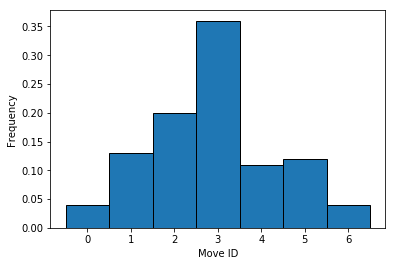

In [104]:
plot_action_frequencies(Connect4State(), budget=100)

Average MCTS Runtime - 0.027807471752166756


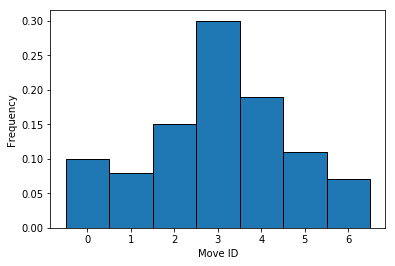

In [105]:
plot_action_frequencies(Connect4State(width=7, height=40), budget=100)

Average MCTS Runtime - 0.03520743608474732


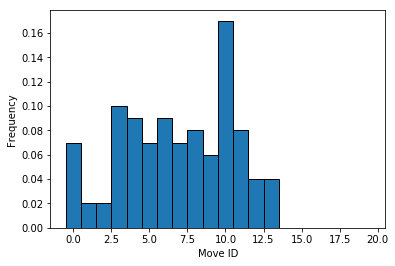

In [109]:
plot_action_frequencies(Connect4State(width=14, height=20, connect=4), budget=100, bins=np.arange(0,21))

In [110]:
def calculate_optimality_of_move(state, bins, budget=5000, runs=100, optimal_move=3, exploration_factor=sqrt(2)):
    x = []
    for i in range(runs):
        move = MCTS_UCT(state, itermax=budget, exploration_factor_ucb1=exploration_factor)
        x += [move]
    density, bins = np.histogram(x, bins=bins, density=True)
    return density[optimal_move]
        
def plot_optimality_of_moves_over_exploration_factor(state, bins=[0,1,2,3,4,5,6], min_value=0, max_value=1, step=0.3):
    optimal_move = int((len(bins)-1)/2)
    y = []
    x = np.arange(min_value, max_value, step)
    for exploration_factor in x:
        move_optimality = calculate_optimality_of_move(state, optimal_move=optimal_move, bins=bins, budget=1000, runs=10, exploration_factor=exploration_factor)
        y += [move_optimality]
    plot.plot(x,y, marker='o', linestyle='--')
    plot.xlabel("Exploration factor")
    plot.ylabel("Move optimality")

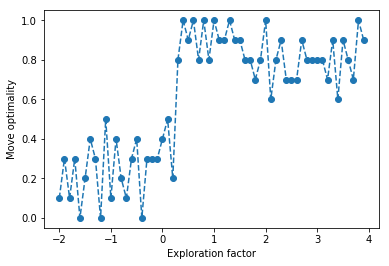

In [111]:
plot_optimality_of_moves_over_exploration_factor(Connect4State(width=7), bins=np.arange(0,8), min_value=-2, max_value=4, step=0.1)

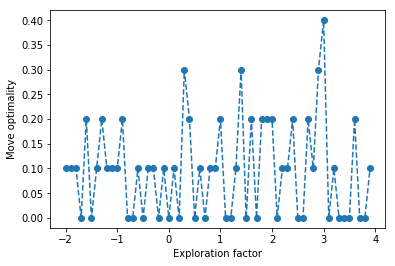

In [112]:
plot_optimality_of_moves_over_exploration_factor(Connect4State(width=11), bins=np.arange(0,12), min_value=-2, max_value=4, step=0.1)

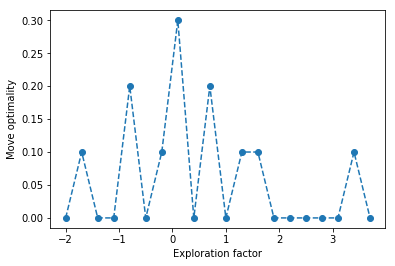

In [113]:
plot_optimality_of_moves_over_exploration_factor(Connect4State(width=21), bins=np.arange(0,22), min_value=-2, max_value=4, step=0.3)

## Robustness to other games

<img src="images/tic-tac-toe.png" alt="drawing" width="300"/>

Tic tac toe needs no introduction ;).

Let's jump straight into the code.

In [22]:
class TicTacToeState(GameState):
    """ A state of the game, i.e. the game board.
        Squares in the board are in this arrangement
        012
        345
        678
        where 0 = empty, 1 = player 1 (X), 2 = player 2 (O)
    """

    def __init__(self):
        self.playerJustMoved = 2  # At the root pretend the player just moved is p2 - p1 has the first move
        self.board = [0, 0, 0, 0, 0, 0, 0, 0, 0]  # 0 = empty, 1 = player 1, 2 = player 2

    def Clone(self):
        """ Create a deep clone of this game state.
        """
        st = TicTacToeState()
        st.playerJustMoved = self.playerJustMoved
        st.board = self.board[:]
        return st

    def DoMove(self, move):
        """ Update a state by carrying out the given move.
            Must update playerToMove.
        """
        assert move >= 0 and move <= 8 and move == int(move) and self.board[move] == 0
        self.playerJustMoved = 3 - self.playerJustMoved
        self.board[move] = self.playerJustMoved

    def GetMoves(self):
        """ Get all possible moves from this state.
        """
        return [i for i in range(9) if self.board[i] == 0]

    def GetResult(self, playerjm):
        """ Get the game result from the viewpoint of playerjm for a finished game.
        """
        for (x, y, z) in [(0, 1, 2), (3, 4, 5), (6, 7, 8), (0, 3, 6), (1, 4, 7), (2, 5, 8), (0, 4, 8), (2, 4, 6)]:
            if self.board[x] == self.board[y] == self.board[z]:
                if self.board[x] == playerjm:
                    return 1.0
                else:
                    return 0.0
        if self.GetMoves() == []: return 0.5  # draw
        assert False  # Should not be possible to get here

    def __repr__(self):
        s = ""
        for i in range(9):
            s += [Fore.WHITE + '.', Fore.GREEN + 'X', Fore.BLUE + 'O'][self.board[i]]
            s += Fore.RESET
            if i % 3 == 2: s += "\n"
        return s

In [24]:
initialState = TicTacToeState()
PlayGame(initialState)

...
...
...

...
.X.
...

O..
.X.
...

O..
XX.
...

O..
XXO
...

O.X
XXO
...

O.X
XXO
O..

OXX
XXO
O..

OXX
XXO
OO.

Nobody wins!


The game ends in a draw everytime! Unsurprisingly, as Tic-tac-toe has been solved for many, many years. If both players play optimally, it leads to a draw. The takeaway is that even though MCTS takes only a few lines of code to write, it can *literally* play optimally for simple games, it reaches an expert level for games like Connect 4, and novice levels for much more complex games like Go. And this is only the vanilla version of MCTS! There are dozens of different variations that improve upon MCTS's *many* initial shortcomings.

Some of these variations include:
+ Tree reusage
+ Loss avoidance
+ Optimistic pruning
+ Information sets for partially observable environments
+ Limited depth rollouts with evaluation functions
+ And many, many more.

For a beautiful overview of all these and many other improvements over the vanilla MCTS, We will leave you with [A survey of Monte Carlo Tree Search methods](http://mcts.ai/pubs/mcts-survey-master.pdf).